In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
df = pd.read_csv("hotel_bookings.csv")

## 2.1 Cramer's V for categorical features

 Cramer's V model based on the chi squared satistic that can show how strongly nominal variables are associated with one another.

In [2]:
df=df.drop('reservation_status',axis=1)

In [3]:
df['is_canceled']=df['is_canceled'].replace([0,1],["no","yes"])

In [4]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols=list(set(cols) - set(num_cols))

In [5]:
df_cat=df[cat_cols]

In [6]:
df_cat.columns

Index(['deposit_type', 'country', 'arrival_date_month', 'assigned_room_type',
       'hotel', 'distribution_channel', 'reserved_room_type',
       'reservation_status_date', 'customer_type', 'meal', 'market_segment',
       'is_canceled'],
      dtype='object')

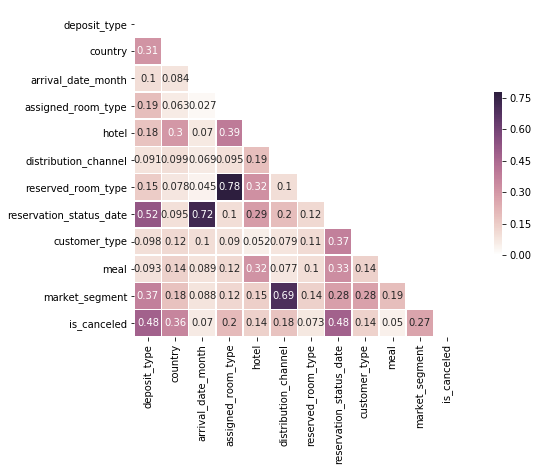

In [7]:
import itertools
import scipy
def cramers_corrected_stat(confusion_matrix):
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
cols = list(df_cat.columns.values)
emp_arr = np.zeros((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    A, B = df_cat[col1], df_cat[col2]
    idx1, idx2 = cols.index(col1), cols.index(col2)
    conf_mat = pd.crosstab(A,B) 
    #appending results to emp_array
    emp_arr[idx1, idx2] = cramers_corrected_stat(conf_mat.values)
    emp_arr[idx2, idx1] = emp_arr[idx1, idx2]
corr = pd.DataFrame(emp_arr, index=cols, columns=cols)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

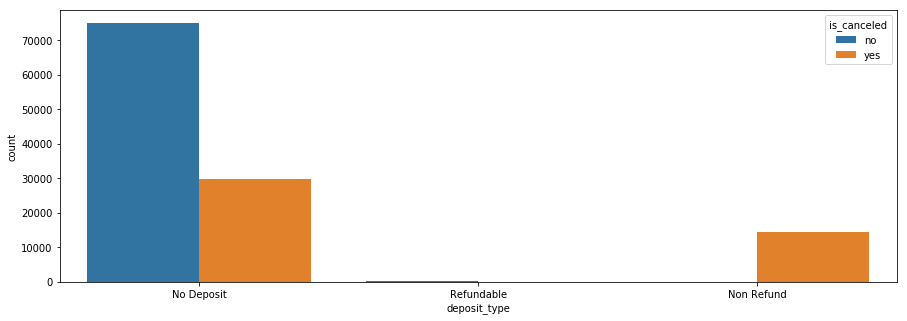

In [8]:
plt.figure(figsize=(15,5))
sns.countplot(x='deposit_type',data=df,hue='is_canceled')

## 2.2 Correlation for numerical features

In [9]:
df['is_canceled']=df['is_canceled'].replace(["no","yes"],[0,1])

In [10]:
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  \
0                        0                     0       2   
1                        0                     0       2   
2                        0                     1       1   
3                        0                     1       1   
4                        0                     2       2   

            ...            booking_changes  deposit_type  agent company  \
0           ...                          3    No Deposit    NaN     NaN   
1           ...                          4    No Deposit    NaN     NaN   
2           ...                          0    No Deposit    NaN     NaN   
3           ...                          0    No Deposit  304.0     NaN   
4           ...                          0    No Deposit  240.0     NaN   

  days_in_waiting_list customer_type   adr  required_car_parking_spaces  \
0                    0     Transient   0.0                            0   
1                    0     Transient   0.0                            0   
2                    0     Transient  75.0                            0   
3                    0     Transient  75.0                            0   
4                    0     Transient  98.0                            0   

   total_of_special_requests reservation_status_date  
0                          0              2015-07-01  
1                          0              2015-07-01  
2                          0              2015-07-02  
3                          0              2015-07-02  
4                          1              2015-07-03  

[5 rows x 31 columns]

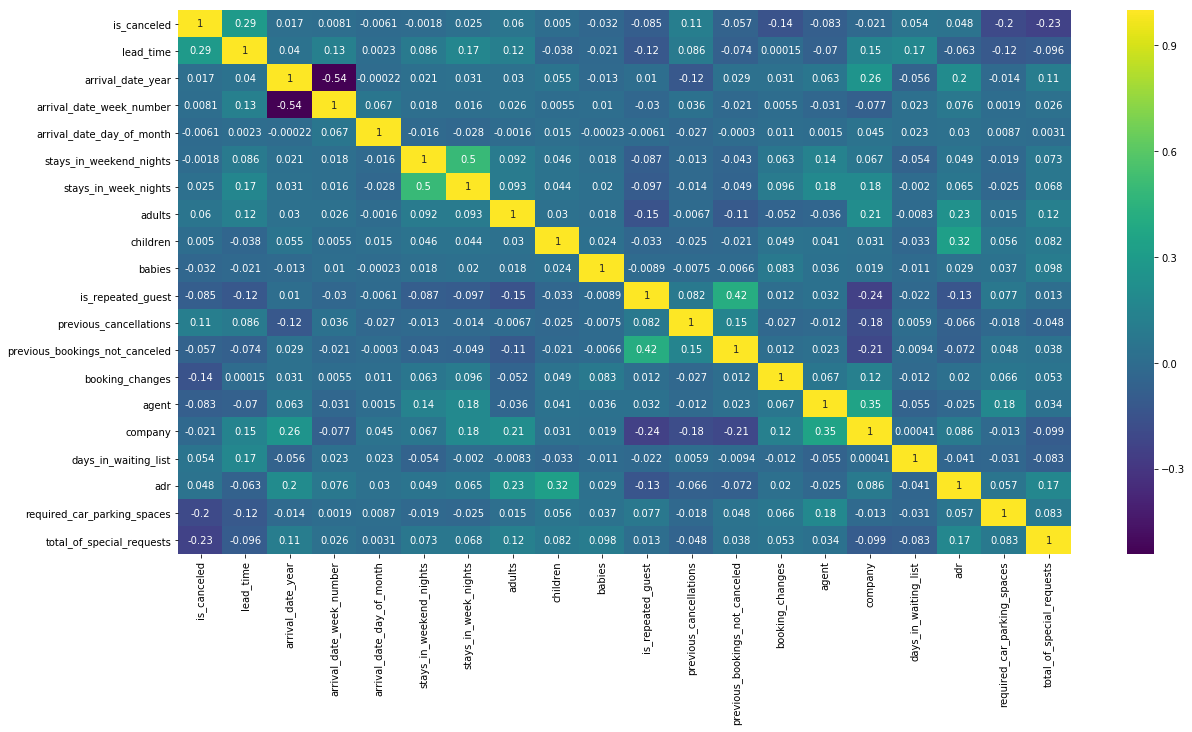

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

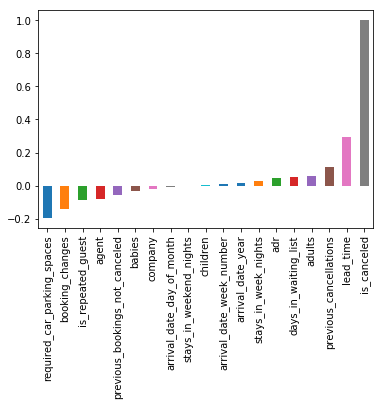

In [12]:
df.corr()['is_canceled'][:-1].sort_values().plot(kind='bar')

# 3. Dimensionality reduction : PCA 

## 3.1 Categorical features only

In [13]:
X_cat = df_cat.drop("is_canceled", axis=1)
y_cat = df_cat["is_canceled"].eq('yes').mul(1)

In [14]:
X_cat.head()

deposit_type country arrival_date_month assigned_room_type         hotel  \
0   No Deposit     PRT               July                  C  Resort Hotel   
1   No Deposit     PRT               July                  C  Resort Hotel   
2   No Deposit     GBR               July                  C  Resort Hotel   
3   No Deposit     GBR               July                  A  Resort Hotel   
4   No Deposit     GBR               July                  A  Resort Hotel   

  distribution_channel reserved_room_type reservation_status_date  \
0               Direct                  C              2015-07-01   
1               Direct                  C              2015-07-01   
2               Direct                  A              2015-07-02   
3            Corporate                  A              2015-07-02   
4                TA/TO                  A              2015-07-03   

  customer_type meal market_segment  
0     Transient   BB         Direct  
1     Transient   BB         Direct  
2     Transient   BB         Direct  
3     Transient   BB      Corporate  
4     Transient   BB      Online TA

In [15]:
X_cat['country'].fillna("No Country", inplace = True)

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def labelencode(df):
    le = LabelEncoder()
    return df.apply(le.fit_transform)

def onehotencode(df):
    onehot = OneHotEncoder()
    return onehot.fit_transform(df).toarray()

X_2 = labelencode(X_cat)
onehotlabels = onehotencode(X_2)

In [17]:
X_2.head().transpose()

0    1    2    3    4
deposit_type               0    0    0    0    0
country                  136  136   59   59   59
arrival_date_month         5    5    5    5    5
assigned_room_type         2    2    2    0    0
hotel                      1    1    1    1    1
distribution_channel       1    1    1    0    3
reserved_room_type         2    2    0    0    0
reservation_status_date  121  121  122  122  123
customer_type              2    2    2    2    2
meal                       0    0    0    0    0
market_segment             3    3    3    2    6

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(onehotlabels)

In [19]:
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

[0.44257446 0.32937114 0.2280544 ]


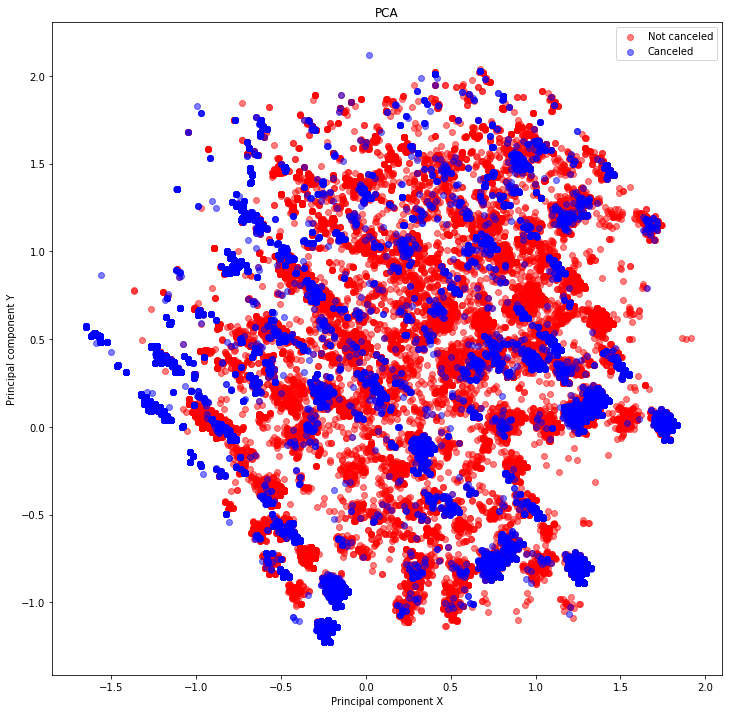

In [20]:
pca = PCA(n_components=len(df_cat.columns))
X_pca = pca.fit_transform(onehotlabels)
X_pca_reconst = pca.inverse_transform(X_pca)
plt.figure(figsize=(12,12))
plt.scatter(X_pca[y_cat==0, 0], X_pca[y_cat==0, 1], color='red', alpha=0.5,label='Not canceled')
plt.scatter(X_pca[y_cat==1, 0], X_pca[y_cat==1, 1], color='blue', alpha=0.5,label='Canceled')
plt.title("PCA")
plt.ylabel('Principal component Y')
plt.xlabel('Principal component X')
plt.legend()
plt.show()

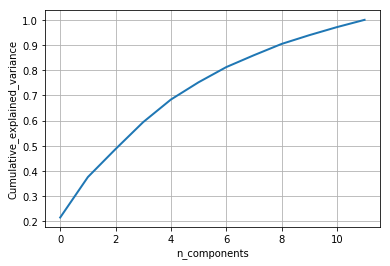

In [21]:
pca = PCA(n_components=len(df_cat.columns))
X_pca = pca.fit_transform(onehotlabels)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()